# WQI prediction with Support Vector Machine regression using Billings reservoir data from CETESB

In [17]:
# Necessary imports for scripts

import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.inspection import permutation_importance
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
from main_file import ml_prediction, scale_dataset, store_metrics, grid_search_optimization

In [18]:
# Variáveis globais

svm_metrics_list = []
rf_metrics_list = []
dt_metrics_list = []
mlp_metrics_list = []

## Dataset

In [19]:
# Receives dataset filepath

dataset_path = "./data/processed/tabela_completa.csv"

In [20]:
# Dataset obtained after preprocessing data

df = pd.read_csv(dataset_path, index_col=[0]) # Creates dataframe (matrix data table) from csv file
df # Show dataframe data

,Código Ponto,Data Coleta,Coliformes Termotolerantes,pH,"DBO (5, 20)",Nitrogênio Total,Fósforo Total,Temperatura da Água,Turbidez,Sólido Total,...,q1,q2,q3,q4,q5,q6,q7,q8,q9,WQI
0,BILL02900,2010-01-28,70.00,7.5,4.00,1.93,0.07,25.9,5.40,112.0,...,43.643440,92.23125,61.049127,85.373277,82.065321,94,86.852790,84.694128,90.792218,76.630444
1,RGDE02200,2010-01-28,740.00,7.2,3.00,1.27,0.04,25.0,4.33,100.0,...,22.962714,92.37120,69.058344,90.118756,89.281641,94,89.316671,85.470000,98.386056,72.648794
2,BILL02100,2010-01-28,400.00,7.2,7.00,2.97,0.05,25.5,5.60,114.0,...,27.628253,92.37120,43.283735,78.436383,86.808316,94,86.401840,84.534352,75.564301,66.791144
3,BITQ00100,2010-01-28,9.00,8.3,5.00,1.86,0.04,26.0,21.70,122.0,...,68.032876,83.20000,53.968800,85.863952,89.281641,94,60.007098,83.808208,88.154226,77.824700
4,BILL02030,2010-01-28,2500.00,7.0,3.00,3.26,0.09,25.6,6.37,104.0,...,15.248005,91.54170,69.058344,76.620043,77.581471,94,84.693878,85.246192,23.743294,51.766023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,BILL02500,2019-12-04,1.25,8.2,3.10,1.29,0.04,24.5,12.60,108.0,...,96.753515,84.80000,68.212268,89.971038,89.281641,94,72.521190,84.987568,93.327908,86.802179
603,BIRP00500,2019-12-04,1.25,7.7,3.00,1.06,0.01,22.6,6.46,100.0,...,96.753515,91.16845,69.058344,91.684569,97.132520,94,84.497168,85.470000,95.854388,90.115264
604,BILL02900,2019-12-04,1.25,8.2,3.00,1.02,0.02,22.6,6.24,100.0,...,96.753515,84.80000,69.058344,91.985878,94.441707,94,84.979094,85.470000,94.722866,88.974960
605,BILL02100,2019-12-04,185.00,7.4,4.30,2.54,0.13,23.1,20.70,162.0,...,34.203646,92.47180,58.832655,81.224284,69.335346,94,61.076498,79.124460,90.685941,69.644568


In [21]:
df['Data Coleta']

0      2010-01-28
1      2010-01-28
2      2010-01-28
3      2010-01-28
4      2010-01-28
          ...    
602    2019-12-04
603    2019-12-04
604    2019-12-04
605    2019-12-04
606    2019-12-04
Name: Data Coleta, Length: 607, dtype: object

In [22]:
# Cast object to date values in 'Data Coleta' column

df['Data Coleta'] = pd.to_datetime(df['Data Coleta'])

In [23]:
# Summarized info about the complete dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Código Ponto                607 non-null    object        
 1   Data Coleta                 607 non-null    datetime64[ns]
 2   Coliformes Termotolerantes  607 non-null    float64       
 3   pH                          607 non-null    float64       
 4   DBO (5, 20)                 607 non-null    float64       
 5   Nitrogênio Total            607 non-null    float64       
 6   Fósforo Total               607 non-null    float64       
 7   Temperatura da Água         607 non-null    float64       
 8   Turbidez                    607 non-null    float64       
 9   Sólido Total                607 non-null    float64       
 10  Oxigênio Dissolvido         607 non-null    float64       
 11  q1                          607 non-null    float64       
 12 

## Train-Test division

In [24]:
# Separate train and test sets according to period of time
# Training -> from 2010 until 2016
# Test -> from 2017 until 2019

training = df[df['Data Coleta'] <= '2016-12-31']
test = df[df['Data Coleta'] > '2016-12-31']

training

,Código Ponto,Data Coleta,Coliformes Termotolerantes,pH,"DBO (5, 20)",Nitrogênio Total,Fósforo Total,Temperatura da Água,Turbidez,Sólido Total,...,q1,q2,q3,q4,q5,q6,q7,q8,q9,WQI
0,BILL02900,2010-01-28,70.00,7.50,4.0,1.93,0.07,25.90,5.40,112.0,...,43.643440,92.231250,61.049127,85.373277,82.065321,94,86.852790,84.694128,90.792218,76.630444
1,RGDE02200,2010-01-28,740.00,7.20,3.0,1.27,0.04,25.00,4.33,100.0,...,22.962714,92.371200,69.058344,90.118756,89.281641,94,89.316671,85.470000,98.386056,72.648794
2,BILL02100,2010-01-28,400.00,7.20,7.0,2.97,0.05,25.50,5.60,114.0,...,27.628253,92.371200,43.283735,78.436383,86.808316,94,86.401840,84.534352,75.564301,66.791144
3,BITQ00100,2010-01-28,9.00,8.30,5.0,1.86,0.04,26.00,21.70,122.0,...,68.032876,83.200000,53.968800,85.863952,89.281641,94,60.007098,83.808208,88.154226,77.824700
4,BILL02030,2010-01-28,2500.00,7.00,3.0,3.26,0.09,25.60,6.37,104.0,...,15.248005,91.541700,69.058344,76.620043,77.581471,94,84.693878,85.246192,23.743294,51.766023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,BILL02900,2016-12-07,1.25,9.03,3.0,1.06,0.05,24.41,33.70,114.0,...,96.753515,44.190000,69.058344,91.684569,86.808316,94,49.207121,84.534352,82.834528,76.248251
401,BILL02100,2016-12-07,37.50,9.85,9.0,2.04,0.27,26.23,74.20,152.0,...,50.383713,22.050000,35.355694,84.608273,46.788924,94,25.525944,80.516160,50.000000,48.119484
402,RGDE02900,2016-12-08,2.50,8.11,3.0,0.59,0.03,24.77,3.49,100.0,...,86.669010,86.240000,69.058344,95.286774,91.825435,94,91.311499,85.470000,93.444351,88.060215
403,RGDE02200,2016-12-08,55.00,9.19,5.0,0.75,0.07,26.48,6.99,100.0,...,46.184917,39.870000,53.968800,94.045319,82.065321,94,83.351169,85.470000,50.000000,62.816286


In [25]:
# Set dependent variables and target variable

X_train = training[['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9']]
X_test = test[['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9']]
y_train = training['WQI']
y_test = test['WQI']

In [26]:
# Scale X and Y values to fit between 0 and 1

X_train = X_train.apply(lambda x: x/100)
X_test = X_test.apply(lambda x: x/100)
y_train = y_train.apply(lambda x: x/100)
y_test = y_test.apply(lambda x: x/100)

X_train.head()

,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,0.436434,0.922313,0.610491,0.853733,0.820653,0.94,0.868528,0.846941,0.907922
1,0.229627,0.923712,0.690583,0.901188,0.892816,0.94,0.893167,0.854700,0.983861
2,0.276283,0.923712,0.432837,0.784364,0.868083,0.94,0.864018,0.845344,0.755643
3,0.680329,0.832000,0.539688,0.858640,0.892816,0.94,0.600071,0.838082,0.881542
4,0.152480,0.915417,0.690583,0.766200,0.775815,0.94,0.846939,0.852462,0.237433


In [27]:
y_train.head()

0    0.766304
1    0.726488
2    0.667911
3    0.778247
4    0.517660
Name: WQI, dtype: float64

In [28]:
X_test.head()

,q1,q2,q3,q4,q5,q6,q7,q8,q9
405,0.684427,0.428400,0.690583,0.941996,0.944417,0.94,0.918670,0.829428,0.934157
406,0.612392,0.390600,0.481466,0.922882,0.868083,0.94,0.716713,0.749494,0.957617
407,0.409409,0.814400,0.353557,0.933539,0.820653,0.94,0.537945,0.730010,0.983907
408,0.239033,0.560114,0.290253,0.898973,0.418157,0.94,0.050000,0.766194,0.851330
409,0.866690,0.425700,0.390713,0.940453,0.844035,0.94,0.498492,0.774544,0.965862


In [29]:
y_test.head()

405    0.781274
406    0.708295
407    0.688715
408    0.449203
409    0.719469
Name: WQI, dtype: float64



# ML regression prediction

In [30]:
# Instanciate optimized models

svm_model = ml_prediction("svm", X_train, X_test, y_train, y_test)
rf_model = ml_prediction("rf", X_train, X_test, y_train, y_test)
dt_model = ml_prediction("dt", X_train, X_test, y_train, y_test)
mlp_model = ml_prediction("mlp", X_train, X_test, y_train, y_test)

## Feature Selection

q9 (OD)                            0.260326
q1 (Coliformes Termotolerantes)    0.211583
q5 (Fósforo Total)                 0.196235
q4 (Nitrogênio Total)              0.091451
q3 (DBO)                           0.081731
q2 (pH)                            0.073522
q7 (Turbidez)                      0.053439
q8 (Sólido Total)                  0.031714
q6 (Temperatura)                   0.000000
dtype: float64


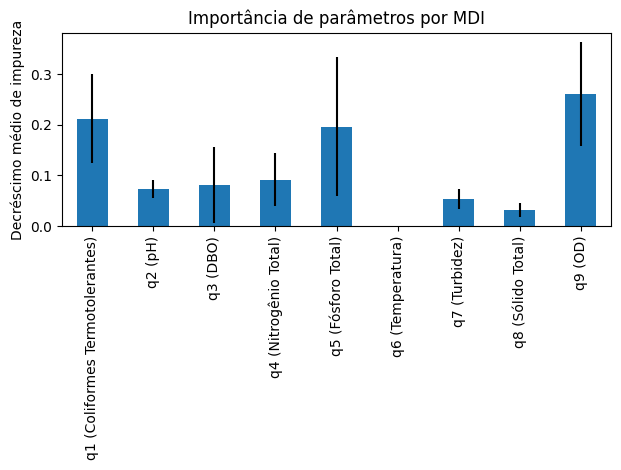

In [31]:
# Get feature impurity-based importance for feature selection (MDI - Mean Decrease Impurity)

importances = rf_model[0].feature_importances_

std = np.std([tree.feature_importances_ for tree in rf_model[0].estimators_], axis=0)

# Plot impurity-based importance

feature_names = ['q1 (Coliformes Termotolerantes)',
                 'q2 (pH)',
                 'q3 (DBO)',
                 'q4 (Nitrogênio Total)',
                 'q5 (Fósforo Total)',
                 'q6 (Temperatura)',
                 'q7 (Turbidez)',
                 'q8 (Sólido Total)',
                 'q9 (OD)']

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Importância de parâmetros por MDI")
ax.set_ylabel("Decréscimo médio de impureza")
fig.tight_layout()

# Show ordered list of parameter importances
print(forest_importances.sort_values(ascending=False))

q1 (Coliformes Termotolerantes)    0.352147
q9 (OD)                            0.246006
q5 (Fósforo Total)                 0.125740
q2 (pH)                            0.071253
q3 (DBO)                           0.051419
q4 (Nitrogênio Total)              0.027025
q7 (Turbidez)                      0.022202
q8 (Sólido Total)                  0.008951
q6 (Temperatura)                   0.000000
dtype: float64


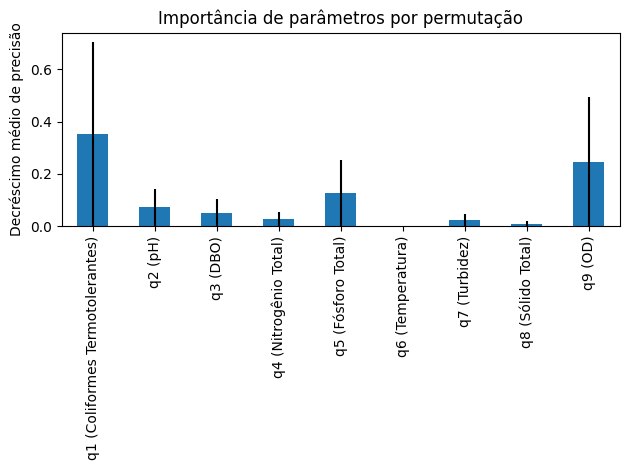

In [32]:
# Get Feature importance based on feature permutation

feature_names = ['q1 (Coliformes Termotolerantes)',
                 'q2 (pH)',
                 'q3 (DBO)',
                 'q4 (Nitrogênio Total)',
                 'q5 (Fósforo Total)',
                 'q6 (Temperatura)',
                 'q7 (Turbidez)',
                 'q8 (Sólido Total)',
                 'q9 (OD)']

result = permutation_importance(
    rf_model[0], X_test, y_test, n_repeats=10, random_state=29, n_jobs=2
)

permutation_importances = pd.Series(result.importances_mean, index=feature_names)

print(permutation_importances.sort_values(ascending=False))

# Plot feature importance based on feature permutation

fig, ax = plt.subplots()
permutation_importances.plot.bar(yerr=result.importances_mean, ax=ax)
ax.set_title(r"Importância de parâmetros por permutação")
ax.set_ylabel(r"Decréscimo médio de precisão")
fig.tight_layout()
plt.show()